<a href="https://colab.research.google.com/github/pacificDeveloperPrakhar/Government-Smart-Vendor-Management-System-/blob/main/labeling_and_running_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow.python.util import compat
from tensorflow.core.protobuf import saved_model_pb2
from google.protobuf import text_format
import pprint
import json
import os

In [2]:
! rm -rf ./models && git clone https://github.com/tensorflow/models.git \
    && sed -i "s#ImageFont.truetype('arial.ttf', 24)#ImageFont.truetype('arial.ttf', 50)#g" ./models/research/object_detection/utils/visualization_utils.py \
    && cp /usr/share/fonts/truetype/dejavu/DejaVuSans.ttf /usr/share/fonts/truetype/dejavu/arial.ttf

Cloning into 'models'...
remote: Enumerating objects: 102078, done.
remote: Counting objects: 100% (186/186), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 102078 (delta 127), reused 95 (delta 82), pack-reused 101892 (from 4)
Receiving objects: 100% (102078/102078), 629.41 MiB | 25.93 MiB/s, done.
Resolving deltas: 100% (72701/72701), done.
cp: cannot stat '/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf': No such file or directory


In [3]:
! cd models/research \
    && protoc object_detection/protos/*.proto --python_out=. \
    && cp object_detection/packages/tf2/setup.py . && \
    python3 -m pip install  .


Processing /content/models/research
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67

In [4]:
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import dataset_util, label_map_util
from object_detection.protos import string_int_label_map_pb2

TypeError: Descriptors cannot be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

In [5]:
pip install protobuf==3.20.*


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.19.0 which is incompatible.
tensorflow-metadata 1.17.1 requires protobuf<6.0.0,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.71.0 requires grpcio>=1.71.0, but you have grpcio 1.65.5 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.
ydf 0.12.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.


In [49]:
# reconstruct frozen graph
def reconstruct(pb_path):
    if not os.path.isfile(pb_path):
        print("Error: %s not found" % pb_path)

    print("Reconstructing Tensorflow model")
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.compat.v1.GraphDef()
        with tf.io.gfile.GFile(pb_path, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    print("Success!")
    return detection_graph

In [5]:
import os
DATA_DIR = './kraggle/input/tacotrashdataset/data'
ANNOTATIONS_FILE = os.path.join(DATA_DIR, 'annotations.json')
NCLASSES = 60
print(os.path.exists(ANNOTATIONS_FILE))

True


In [65]:
# visualize detection
def image2np(image):
    (w, h) = image.size
    return np.array(image.getdata()).reshape((h, w, 3)).astype(np.uint8)

def image2tensor(image):
    npim = image2np(image)
    return np.expand_dims(npim, axis=0)

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2

def detect(graph, path_to_image, output_json_path='output.json'):
    results = []

    with graph.as_default():
        with tf.compat.v1.Session(graph=graph) as sess:
            image_tensor = graph.get_tensor_by_name('image_tensor:0')
            boxes = graph.get_tensor_by_name('detection_boxes:0')
            scores = graph.get_tensor_by_name('detection_scores:0')
            classes = graph.get_tensor_by_name('detection_classes:0')
            num_detections = graph.get_tensor_by_name('num_detections:0')

            image = Image.open(path_to_image)
            image_np = np.array(image)
            image_np_expanded = np.expand_dims(image_np, axis=0)

            (boxes_out, scores_out, classes_out, num_detections_out) = sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: image_np_expanded}
            )

            boxes_out = np.squeeze(boxes_out)
            scores_out = np.squeeze(scores_out)
            classes_out = np.squeeze(classes_out).astype(np.int32)

            # Build JSON results for scores > 0.5
            for i in range(int(num_detections_out[0])):
                if scores_out[i] > 0.5:
                    label = category_index[classes_out[i]]['name']
                    results.append({
                        'label': label,
                        'score': float(scores_out[i]),
                        'box': [float(x) for x in boxes_out[i]]
                    })

            # Save to JSON file
            with open(output_json_path, 'w') as f:
                json.dump(results, f, indent=2)

            # Visualize with larger font (50 instead of 24)
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                boxes_out,
                classes_out,
                scores_out,
                category_index,
                use_normalized_coordinates=True,
                line_thickness=6,
                min_score_thresh=0.5
            )

            # Display
            plt.figure(figsize=(12, 8))
            plt.imshow(image_np)
            plt.axis('off')
            plt.show()

    print(f"Detection results saved to: {output_json_path}")

In [55]:
import pprint
from google.protobuf import text_format
from object_detection.protos import string_int_label_map_pb2
import json

In [56]:
with open(ANNOTATIONS_FILE) as json_file:
    data = json.load(json_file)

categories = data['categories']

In [57]:
from object_detection.protos import string_int_label_map_pb2
print('Building label map from examples')

labelmap = string_int_label_map_pb2.StringIntLabelMap()
for idx,category in enumerate(categories):
    item = labelmap.item.add()
    # label map id 0 is reserved for the background label
    item.id = int(category['id'])+1
    item.name = category['name']

with open('./labelmap.pbtxt', 'w') as f:
    f.write(text_format.MessageToString(labelmap))

print('Label map witten to labelmap.pbtxt')

with open('./labelmap.pbtxt') as f:
    pprint.pprint(f.readlines())

Building label map from examples
Label map witten to labelmap.pbtxt
['item {\n',
 '  name: "Aluminium foil"\n',
 '  id: 1\n',
 '}\n',
 'item {\n',
 '  name: "Battery"\n',
 '  id: 2\n',
 '}\n',
 'item {\n',
 '  name: "Aluminium blister pack"\n',
 '  id: 3\n',
 '}\n',
 'item {\n',
 '  name: "Carded blister pack"\n',
 '  id: 4\n',
 '}\n',
 'item {\n',
 '  name: "Other plastic bottle"\n',
 '  id: 5\n',
 '}\n',
 'item {\n',
 '  name: "Clear plastic bottle"\n',
 '  id: 6\n',
 '}\n',
 'item {\n',
 '  name: "Glass bottle"\n',
 '  id: 7\n',
 '}\n',
 'item {\n',
 '  name: "Plastic bottle cap"\n',
 '  id: 8\n',
 '}\n',
 'item {\n',
 '  name: "Metal bottle cap"\n',
 '  id: 9\n',
 '}\n',
 'item {\n',
 '  name: "Broken glass"\n',
 '  id: 10\n',
 '}\n',
 'item {\n',
 '  name: "Food Can"\n',
 '  id: 11\n',
 '}\n',
 'item {\n',
 '  name: "Aerosol"\n',
 '  id: 12\n',
 '}\n',
 'item {\n',
 '  name: "Drink can"\n',
 '  id: 13\n',
 '}\n',
 'item {\n',
 '  name: "Toilet tube"\n',
 '  id: 14\n',
 '}\n',
 'it

In [58]:

label_map = label_map_util.load_labelmap('labelmap.pbtxt')
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NCLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [59]:
detection_graph = reconstruct("./kraggle/model/ssd_mobilenet_v2_taco_2018_03_29.pb")

Reconstructing Tensorflow model
Success!


In [60]:
from object_detection.utils import visualization_utils as vis_util



In [61]:
from PIL import Image
import numpy as np
print(os.path.exists("./kraggle/input/tacotrashdataset/data/custom_training_data/test1.jpg"))



True


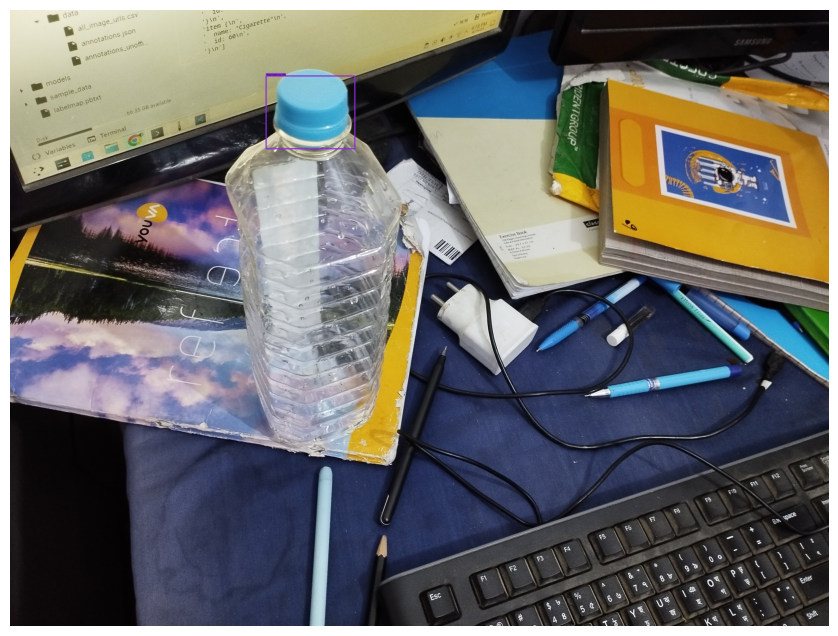

Detection results saved to: output.json


In [66]:
detect(detection_graph, './kraggle/input/tacotrashdataset/data/custom_training_data/test1.jpg')
